[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/worldcoin/open-iris/blob/main/colab/GettingStarted.ipynb)

# IRIS: _Getting started_ tutorial

This Jupyter Notebook will walk you through you the basics of usage `iris` package. From it you will learn how to:
- Perform an `IRISPipeline` inference call.
- Configure `IRISPipeline` environment to modify error handling and return behaviour.
- Visualize `IRISPipeline` intermediate results.

## 0. Installing `iris` package in the `SERVER` environment.

Install `iris` package

In [1]:
!pip install onnx onnxruntime pydantic==1.10.16 huggingface-hub pyyaml
!pip install --no-deps open-iris

Verify installation by printing `iris` version

In [2]:
import iris

print(iris.__version__)

1.9.7


/mnt/oldhome/nishkal/dd/iris-code/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Download sample IR image for experimenting.

In [3]:
!wget https://wld-ml-ai-data-public.s3.amazonaws.com/public-iris-images/example_orb_image_1.png -O ./sample_ir_image.png

--2025-10-22 14:36:59--  https://wld-ml-ai-data-public.s3.amazonaws.com/public-iris-images/example_orb_image_1.png
Resolving wld-ml-ai-data-public.s3.amazonaws.com (wld-ml-ai-data-public.s3.amazonaws.com)... 52.217.171.81, 16.15.182.207, 16.15.200.21, ...
Connecting to wld-ml-ai-data-public.s3.amazonaws.com (wld-ml-ai-data-public.s3.amazonaws.com)|52.217.171.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 875520 (855K) [image/png]
Saving to: ‘./sample_ir_image.png’

./sample_ir_image.p 100%[===================>] 855.00K   670KB/s    in 1.3s    

2025-10-22 14:37:01 (670 KB/s) - ‘./sample_ir_image.png’ saved [875520/875520]



## 1. Running the `IRISPipeline` inference

Load IR image with `opencv-python` package.

[ WARN:0@2.972] global loadsave.cpp:275 findDecoder imread_('./001_1_1.jpg'): can't open/read file: check file path/integrity


TypeError: Image data of dtype object cannot be converted to float

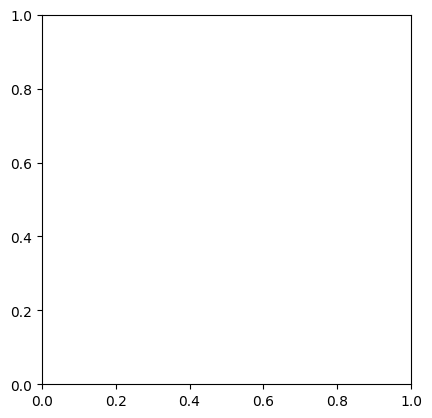

In [ ]:
import cv2
import matplotlib.pyplot as plt

img_pixels = cv2.imread("/", cv2.IMREAD_GRAYSCALE)
plt.imshow(img_pixels, cmap='gray')

Create `IRISPipeline` object

In [ ]:
iris_pipeline = iris.IRISPipeline()

Run `IRISPipeline` inference.
There are several methods that wraps `IRISPipeline` inference call. Each one of them leads to the same source code being called. Possible options are:
1) Using `__call__` operator
2) Using `run` method
3) Using `estimate` method

```python
# Options for the `eye_side` argument are: ["left", "right"]
output = iris_pipeline(iris.IRImage(img_data=img_pixels, image_id="image_id", eye_side="right"))
output = iris_pipeline.run(iris.IRImage(img_data=img_pixels, image_id="image_id", eye_side="right"))
output = iris_pipeline.estimate(iris.IRImage(img_data=img_pixels, image_id="image_id", eye_side="right"))
```

In [ ]:
output = iris_pipeline(iris.IRImage(img_data=img_pixels, image_id="image_id", eye_side="right"))

The output of `IRISPipeline` is a dictionary with following keys:

In [ ]:
output.keys()

dict_keys(['error', 'iris_template', 'metadata'])

The `error` value contains information about potential exceptions being raised during performing inference. The `IRISPipeline` implements the concept of a state machine. Therefore, error handling is done through setting an appropriate variable and returning it to user for inference success status verification.

If `output["error"]` value is `None`, `IRISPipeline` finished inference call without any exception being raised. If the `IRISPipeline` raised some exception when performing an inference, `output["error"]` value will be a  `dict`, containing three keys: `["error_type", "message", "traceback"]`. An example of `output["error"]` with an error looks like:
```python
{
    'error_type': 'TypeError',
    'message': "run() got an unexpected keyword argument 'segmentation_map2'",
    'traceback': 'Very long exception traceback'
}
```

In [ ]:
# Verify IRISPipeline inference call finished without any exception being raised
output["error"] is None

True

The `iris_template` value contains generated by the `IRISPipeline` iris code for an iris texture visible in the input image. The `output["iris_template"]` value is a `IrisTemplate` object containing two fields: `["iris_codes: List[np.ndarray]", "mask_codes: List[np.ndarray]"]`.

Each code available in `output["iris_template"]` object is a `numpy.ndarray` of shape `(16, 256, 2)`. The length of arrays containing iris codes and mask codes is determined by `IRISPipeline` filter bank parameters. The iris/mask code shape's dimmensions correspond to the following `(iris_code_height, iris_code_width, 2)`. Values `iris_code_height` and `iris_code_width` are determined by `ProbeSchema`'s definition for `ConvFilterBank` object and `num_filters` is determined by number of filters specified for `ConvFilterBank` object. The last `2` value of the iris/mask code dimmension corresponds to the real and imaginary parts of each complex filter response.

_NOTE_: More about how to specify those parameters and configuring custom `IRISPipeline` can be found in the _Configuring custom pipeline_ tutorial.

In [ ]:
"""Available fields in `output["iris_template"]` are: """ + str(output["iris_template"].__fields__)

'Available fields in `output["iris_template"]` are: {\'iris_codes\': ModelField(name=\'iris_codes\', type=List[ndarray], required=True), \'mask_codes\': ModelField(name=\'mask_codes\', type=List[ndarray], required=True), \'iris_code_version\': ModelField(name=\'iris_code_version\', type=str, required=True)}'

In [ ]:
num_codes = len(output["iris_template"].iris_codes)
code_shape = output["iris_template"].iris_codes[0].shape

f"""Number of returned iris codes is equal to {num_codes} and each code shape is {code_shape}"""

'Number of returned iris codes is equal to 2 and each code shape is (16, 256, 2)'

The `metadata` value contains additional information that may be useful for further processing or quality analisys. Metadata information contain in this dictionary presents as follow.

In [ ]:
output["metadata"]

{'iris_version': '1.9.7',
 'image_id': 'image_id',
 'image_size': (320, 280),
 'eye_side': 'right',
 'eye_centers': {'iris_center': (177.48051808205966, 137.2971728148795),
  'pupil_center': (181.94742545330357, 134.7162782201269)},
 'pupil_to_iris_property': {'pupil_to_iris_diameter_ratio': 0.3878222863041983,
  'pupil_to_iris_center_dist_ratio': np.float64(0.05217582718863587)},
 'offgaze_score': 3.73082000888141e-05,
 'eye_orientation': np.float64(-0.055496199848637406),
 'occlusion90': np.float64(0.8218605004944094),
 'occlusion30': np.float64(0.9825064726051361),
 'iris_bbox': {'x_min': 79.08786010742188,
  'y_min': 38.76966857910156,
  'x_max': 276.2251281738281,
  'y_max': 235.930908203125},
 'sharpness_score': 1681.1151123046875}

Configuring pipelines error handling and which intermediate results are returned can be achived through `Environment` parameter set when the `IRISPipeline` is instantiate. To understand more about that subject please follow to the notebook's next section - _2. Configuring `IRISPipeline` environment_.

----
## 2. Configuring `IRISPipeline` environment

Before diving deeper into how exactly one can modify error handling or return behaviour let's first investigate what are `IRISPipeline` instantiation parameters. The `IRISPipeline`'s `__init__` method presents as follow.

```python
def __init__(
    self,
    config: Union[Dict[str, Any], Optional[str]] = None,
    env: Environment = Environment(
        pipeline_output_builder=build_orb_output,
        error_manager=store_error_manager,
        call_trace_initialiser=PipelineCallTraceStorage.initialise,
    ),
) -> None:
```

There are two parameters we can specify:
1) `config: Union[Dict[str, Any], Optional[str]]` - refers to `IRISPipeline` configuration that specified what nodes pipeline has and how all of them are orchestrated/connected into pipeline graph. How to configure pipeline graph is a subject of the tutorial _Configuring custom pipeline_ tutorial.
   
2) `env: Environment` - refers to `IRISPipeline` enviroment that manages error handling and return behaviour of the `IRISPipeline`.

From that we can see that in order to modify error handling or return behaviour we have to introduce our own `Environment` object when creating the `IRISPipeline` object. The `Environment` object is defined as follow.

```python
class Environment(ImmutableModel):
    call_trace_initialiser: Callable[[Dict[str, Algorithm], List[PipelineNode]], PipelineCallTraceStorage]
    pipeline_output_builder: Callable[[PipelineCallTraceStorage], Any]
    error_manager: Callable[[PipelineCallTraceStorage, Exception], None]
    disabled_qa: List[type] = []
```
Parameters of the `Environment` class are responsible for following:
- `call_trace_initialiser` - is responsible for initialising the `PipelineCallTraceStorage` instance in the pipeline.
  
- `pipeline_output_builder` - is responsible for building the pipeline output from the `call_trace`, which kept all intermediary results so far.
- `error_manager` - is responsible for the pipeline's behaviour in case of an exception
- `disabled_qa` - stores a list of `Algorithm`s and/or `Callback`s types to be disabled when performing an inference call.

Apart from `Environment` that `IRISPipeline` has setup by default, it also provides additional `Environment` that user can set. `Environment` is defined within `IRISPipeline` and is called `DEBUGGING_ENVIRONMENT`. As name suggest, this `Environment` is useful whenever user wants to debug pipeline by getting more insights on information flowing through the system. The `DEBUGGING_ENVIRONMENT` is defined as follow.

```python
DEBUGGING_ENVIRONMENT = Environment(
    pipeline_output_builder=build_debugging_output,
    error_manager=store_error_manager,
    disabled_qa=[
        iris.nodes.validators.object_validators.Pupil2IrisPropertyValidator,
        iris.nodes.validators.object_validators.OffgazeValidator,
        iris.nodes.validators.object_validators.OcclusionValidator,
        iris.nodes.validators.object_validators.IsPupilInsideIrisValidator,
        iris.nodes.validators.object_validators.IsMaskTooSmallValidator,
        iris.nodes.validators.cross_object_validators.EyeCentersInsideImageValidator,
        iris.nodes.validators.cross_object_validators.ExtrapolatedPolygonsInsideImageValidator,
    ],
    call_trace_initialiser=PipelineCallTraceStorage.initialise,
)
```

Let's test it and see the output of the `IRISPipeline` with `DEBUGGING_ENVIRONMENT` set.

In [ ]:
iris_pipeline = iris.IRISPipeline(env=iris.IRISPipeline.DEBUGGING_ENVIRONMENT)

output = iris_pipeline(iris.IRImage(img_data=img_pixels, image_id="image_id", eye_side="right"))

In the same manner, we can investigate what has been returned from `DEBUGGING_ENVIRONMENT` and we can see that more intermediate result are available for us in the `output` dictionary.

In [ ]:
output.keys()

dict_keys(['iris_template', 'metadata', 'segmentation_map', 'segmentation_binarization', 'extrapolated_polygons', 'normalized_iris', 'iris_response', 'iris_response_refined', 'error'])

User can also create and introduce to `IRISPipeline` their own `Environment` variables as far as they fulfill `Environment` class variables typings. For examples, please checkout `iris.orchestration.output_builders` module.

----
## 3. Visualizing results

The `iris` package provides also a useful module for plotting intermediate results - `iris.visualisation`. The main class of the module - `IRISVisualizer` - provides a bunch of plot functions that given appropriate intermediate result creates a ready to dispay `Canvas`. Definition of the `Canvas` type looks like follow.

```python
Canvas = Tuple[matplotlib.figure.Figure, Union[matplotlib.axes._axes.Axes, np.ndarray]]
```

In order to utilize `iris` package visualisation mechanisms, we have start with creating the `IRISVisualizer` class.

In [ ]:
iris_visualizer = iris.visualisation.IRISVisualizer()

Having that done, we can use it's method by either providing `iris` package specific dataclasses or their serialized versions.

_NOTE_: Available by default `IRISPipeline`'s `Environment`s return serialized version of `iris` dataclasses objects. That behaviour can be changed by creating and specifying as the `IRISPipeline` parameter your own custom `Environment` class object (see Section 2 for more details how to do that).

Below you can find a bunch of exemplary `iris_visualizer` plotting methods calls.

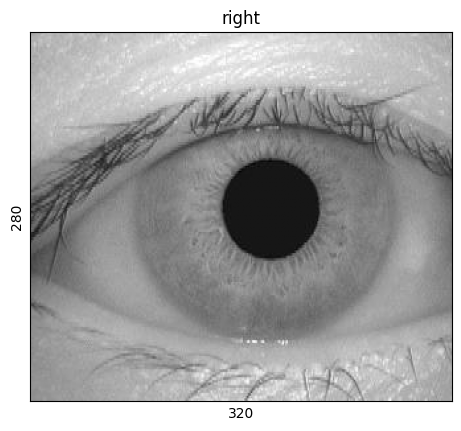

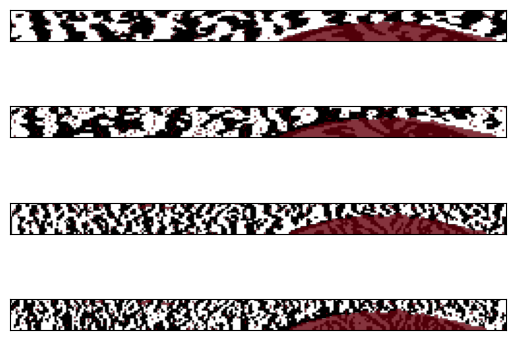

In [ ]:
import matplotlib.pyplot as plt

canvas = iris_visualizer.plot_ir_image(iris.IRImage(img_data=img_pixels, eye_side="right"))
plt.show()

canvas = iris_visualizer.plot_iris_template(output["iris_template"])
plt.show()

In [ ]:
output['metadata']['eye_side']

'right'

---
## 4. Visualising intermediary results

Here is how you can access the actual list of nodes (i.e. the graph of algorithms that were used to process the input image into an iris code) used in the iris pipeline

In [ ]:
iris_pipeline.params.pipeline

[PipelineNode(name='segmentation', algorithm=PipelineClass(class_name='iris.MultilabelSegmentation.create_from_hugging_face', params={'denoise': True}), inputs=[PipelineInput(name='image', index=None, source_node='input')], callbacks=None, seed=None),
 PipelineNode(name='segmentation_binarization', algorithm=PipelineClass(class_name='iris.MultilabelSegmentationBinarization', params={}), inputs=[PipelineInput(name='segmentation_map', index=None, source_node='segmentation')], callbacks=None, seed=None),
 PipelineNode(name='vectorization', algorithm=PipelineClass(class_name='iris.ContouringAlgorithm', params={}), inputs=[PipelineInput(name='geometry_mask', index=0, source_node='segmentation_binarization')], callbacks=None, seed=None),
 PipelineNode(name='specular_reflection_detection', algorithm=PipelineClass(class_name='iris.SpecularReflectionDetection', params={}), inputs=[PipelineInput(name='ir_image', index=None, source_node='input')], callbacks=None, seed=None),
 PipelineNode(name='i

These are declared in the yaml file used to define the computation graph. By delaut, it is located at `src/iris/pipelines/confs/pipeline.yaml`

The iris pipeline object stores all intermediary results from the previous computation in its `call_trace`. This is reseted at every call, so only the latest intermediary results are available

In [ ]:
iris_pipeline.call_trace['segmentation']

SegmentationMap(predictions=array([[[5.9604645e-08, 3.2782555e-07, 8.9406967e-08, 1.8477440e-06],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.9802322e-08],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.9802322e-08],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.000000

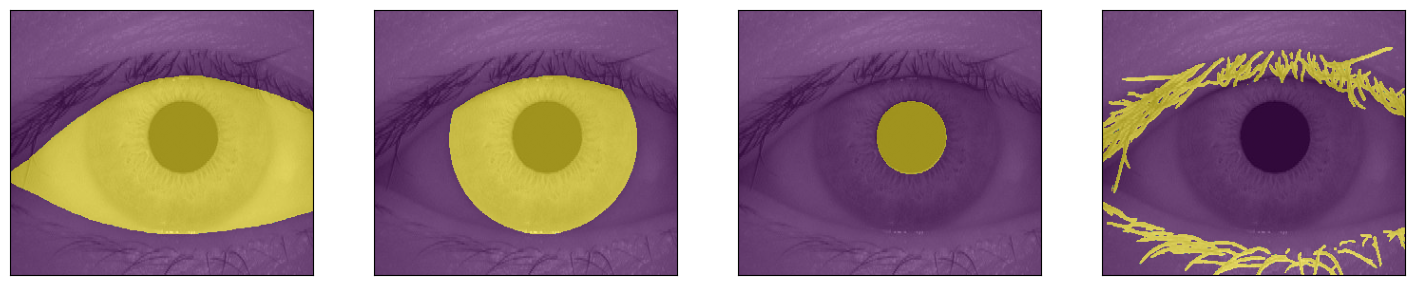

In [ ]:
canvas = iris_visualizer.plot_segmentation_map(
    ir_image=iris.IRImage(img_data=img_pixels, eye_side="right"),
    segmap=iris_pipeline.call_trace['segmentation'],
)
plt.show()

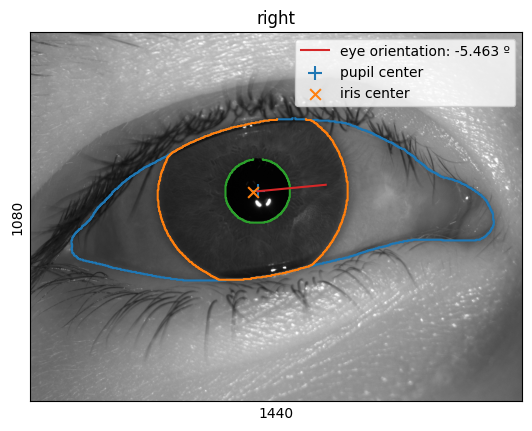

In [ ]:
canvas = iris_visualizer.plot_all_geometry(
    ir_image=iris.IRImage(img_data=img_pixels, eye_side="right"),
    geometry_polygons=iris_pipeline.call_trace['vectorization'],
    eye_orientation=iris_pipeline.call_trace['eye_orientation'],
    eye_center=iris_pipeline.call_trace['eye_center_estimation'],
)
plt.show()

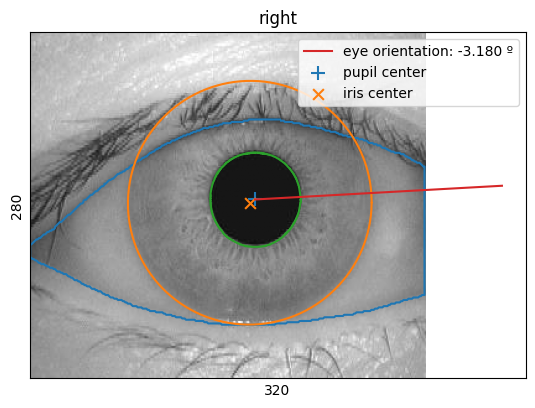

In [ ]:
canvas = iris_visualizer.plot_all_geometry(
    ir_image=iris.IRImage(img_data=img_pixels, eye_side="right"),
    geometry_polygons=iris_pipeline.call_trace['geometry_estimation'],
    eye_orientation=iris_pipeline.call_trace['eye_orientation'],
    eye_center=iris_pipeline.call_trace['eye_center_estimation'],
)
plt.show()

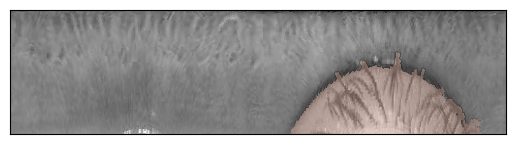

In [ ]:
canvas = iris_visualizer.plot_normalized_iris(
    normalized_iris=iris_pipeline.call_trace['normalization'],
)
plt.show()

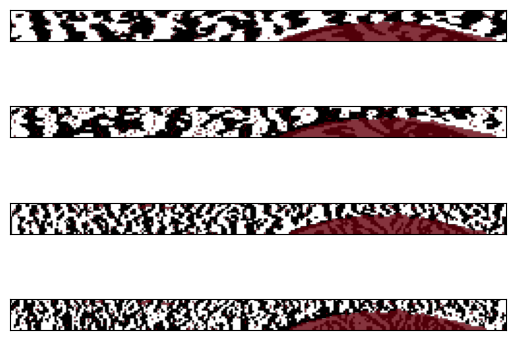

In [ ]:
canvas = iris_visualizer.plot_iris_template(
    iris_template=iris_pipeline.call_trace['encoder'],
)
plt.show()

List of all available `IRISVisualizer` methods can be found in the `iris` package documentation.

### Thank you for making it to the end of this tutorial!